# 1. Parallel computing with dask.delayed

This notebook is heavily based on [this](https://github.com/dask/dask-tutorial/blob/master/01_dask.delayed.ipynb) official dask tutorial.

We first "reserve" some CPU. We will see in the next chapter exactly how this is done. 

In [1]:
from time import sleep
from dask.distributed import Client

In [2]:
client = Client()

There are two simple situations where we can benefit from parallelization: we can have a series of **independent** functions e.g. in a data processing pipeline, or we can have multiple **independent** calls to a given function in a for loop. Let's see the first case, and learn how Dask deals with it.

## Delaying computation

For the purpose of illustration, we imagine that we have two functions that are slow to execute. To simulate the slowness we just pause execution within the functions for a few seconds using ```time.sleep```, let's say here 1s.

In [4]:
def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

If we use the timing magic function we can check that the following "script" takes 3s:

In [5]:
%%time
x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 71.3 ms, sys: 12.5 ms, total: 83.8 ms
Wall time: 3.01 s


In principle we could execute the two first lines in parallel as the variables are indpendent. The solution implemented by Dask is the following:
- "Take notes" on what the program should be doing
- With that information, smartly split the problem into subproblems
- Send each problem to an individual process (e.g. two cores)

So how do we tell Dask what tasks it should take into account when "taking notes"? The solution is to use the function ```delayed()``` which takes as input another function. Every function "decorated" with the delay function will be included in the Dask flow. Let's try it:

In [6]:
from dask import delayed

In [7]:
%%time
x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 744 µs, sys: 303 µs, total: 1.05 ms
Wall time: 1.04 ms


We see that the time consumed is minimal. But has z been really calculated ? 

In [8]:
z

Delayed('add-4f392fa2-52a4-4c24-b117-f7cd38baf2b1')

No! ```z``` is also a delayed object now. Dask *knows* how to calculate it but *hasn't done it yet*. To effectively get the result of z, we have to use the ```compute()``` function or method:

In [9]:
%%time
z.compute()

CPU times: user 63.7 ms, sys: 10.3 ms, total: 74 ms
Wall time: 2.03 s


5

The computation time is now only 2s instead of 3. Indeed the two first calls to ```inc``` could be done in parallel, making us gain 1s in the process.

## What is Dask actually doing: Task graph

Dask offers a very useful way to visualize how the task are split through the ```visualize()``` method that one can use on any delayed variable. Let's check e.g. what is ```z```:

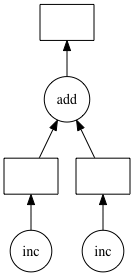

In [10]:
z.visualize()

Each "leaf" of that tree starts and indepenent calculation that can be sent to an independent process if available. Here the two ```inc()``` calls start separately and are then combined in the ```add()``` call.

Generating this **Task graph** and handling the flow of information beetween processes is **the main task of Dask**.

We can make our calculation slighly more complex and see what happens:

In [11]:
%%time
x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

x2 = delayed(inc)(1)
y2 = delayed(inc)(2)
z2 = delayed(add)(x2, y2)

total = delayed(add)(z, z2)

CPU times: user 835 µs, sys: 259 µs, total: 1.09 ms
Wall time: 1.16 ms


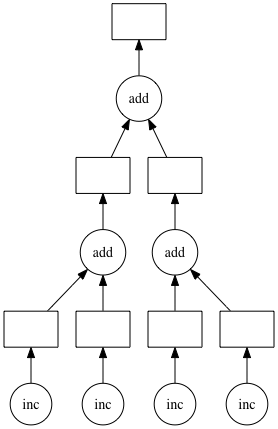

In [12]:
total.visualize()

Let's however look at alternative ways of caclulating this last sum. First, what happens if we just use a regualr ```+``` sign ?

In [13]:
total_plus = z + z2

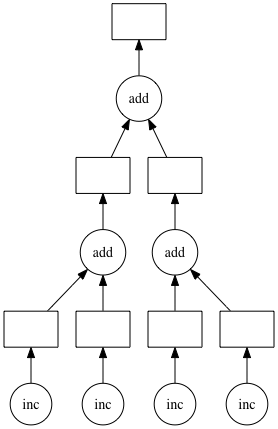

In [14]:
total_plus.visualize()

We obtain exactly the same graph. Dask knows about standard operations and automatically includes them in the task graph. Let's see if we us the standard Python ```sum()``` function: 

In [15]:
total_sum = sum([z, z2])

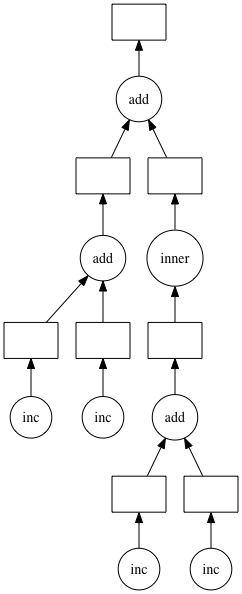

In [16]:
total_sum.visualize()

We now see an **important** difference! ```z``` and ```z2``` are calculated in **sequence** and not in parallel (except for their "internal definitions"). What happens here is that ```sum()``` not beeing included in the task graph, triggers the computation first of ```z``` and **then** of ```z2```.

This shows that one should be careful when using ```delay()``` for parallelization. Other recommendations are: not delaying a delayed function, breaking long code into multiple delayed functions etc. (see [here](https://docs.dask.org/en/latest/delayed-best-practices.html) for more details).

## Exercises

If you haven't executed the notebook unil now, import the packages and start the client.

In [ ]:
from dask.distributed import Client
from dask import delayed
client = Client()

Based on what we just learned apply the ```inc()``` function on the list ```data``` (using a for loop or a comprehension list) and then multiply all elements using the numpy function ```np.prod()```. Check the task graph to make sure everyting happens as expected:

In [18]:
data = [3,8,1,4,2,9,4,6]